# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [187]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
from sqlalchemy import create_engine
import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

%inline matplotlib

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sgkey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sgkey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sgkey\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
UsageError: Line magic function `%inline` not found.


In [146]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('1st',engine)
#df.isna().sum

In [147]:
df.shape

(26216, 40)

In [176]:
X = df.message.values
Y = df.drop(["message","id","original","genre"],axis = 1).values

In [55]:
df_genre_scatter = df.groupby("genre").sum().drop(["id"],axis = 1)
df_genre_scatter

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
genre,,,,,,,,,,,,,,,,,,,,,
direct,7446,3696,46,4338,592,471,216,131,46,0,...,78,186,1521,304,315,41,796,63,207,3613
news,10707,604,65,5860,1415,793,441,292,801,0,...,218,866,4280,1747,1445,225,910,415,1052,852
social,2129,174,7,662,77,49,67,48,13,0,...,13,99,1496,104,683,16,749,52,117,610


In [82]:
first_gen = df_genre_scatter[1:2]
first_gen.values[0]
first_gen.index[0]
df.related.value_counts()

1    19906
0     6122
2      188
Name: related, dtype: int64

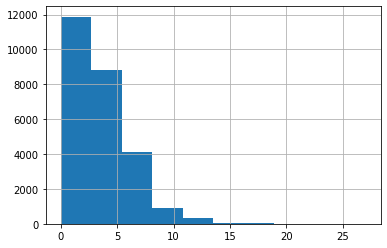

In [137]:
df_cate_hist = df.drop(["message","id","original","genre"],axis = 1)
df_cate_hist["count_cate"] = df_cate_hist.sum(axis = 1)
df_cate_hist["count_cate"].hist()

### 2. Write a tokenization function to process your text data

In [5]:
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [150]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(MultinomialNB()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [177]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
# train classifier
pipeline.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x00000251000CD378>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=MultinomialNB(alpha=1.0,
         

In [152]:
# predict on test data
Y_pred = pipeline.predict(X_test)

In [9]:
col_list = df.drop(["message","id","original","genre"],axis = 1).columns
col_list

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [24]:
#target_names = ['class 0', 'class 1']
def show_result(col_list,Y_test,Y_pred):
    for i, col in enumerate(col_list):
        print (col+":")
        print(classification_report(Y_test[i], Y_pred[i]))

show_result(col_list,Y_test,Y_pred)

related:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.00      0.00      0.00         0

    accuracy                           0.97        36
   macro avg       0.50      0.49      0.49        36
weighted avg       1.00      0.97      0.99        36

request:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       1.00      0.33      0.50         3

    accuracy                           0.94        36
   macro avg       0.97      0.67      0.74        36
weighted avg       0.95      0.94      0.93        36

offer:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

aid_related:
              precision    recall  

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [138]:
#pipeline.get_params()

### 6. Improve your model
Use grid search to find better parameters. 

In [20]:
parameters = {
#        'vect__ngram_range': ((1, 1), (1, 2)),
#        'vect__max_df': (0.5, 0.75, 1.0),
#        'vect__max_features': (None, 5000, 10000),
#        'tfidf__use_idf': (True, False),
#        'clf__estimator__n_neighbors': [2, 5, 10],
        'clf__estimator__weights': ['uniform','distance'],
#        'clf__estimator__p': [1,2]
 }

cv = GridSearchCV(pipeline, param_grid=parameters)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [21]:
cv.fit(X_train, Y_train)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                       

In [22]:
Y_pred = cv.predict(X_test)

In [25]:
print("Classification Report:\n")
show_result(col_list,Y_test,Y_pred)
print("\nBest Parameters:", cv.best_params_)


Classification Report:

related:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.00      0.00      0.00         0

    accuracy                           0.97        36
   macro avg       0.50      0.49      0.49        36
weighted avg       1.00      0.97      0.99        36

request:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       1.00      0.33      0.50         3

    accuracy                           0.94        36
   macro avg       0.97      0.67      0.74        36
weighted avg       0.95      0.94      0.93        36

offer:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

aid_related:
           

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF  

Let’s see if we can do better with a linear support vector machine (SVM), which is widely regarded as one of the best text classification algorithms (although it’s also a bit slower than naïve Bayes).

In [178]:
from sklearn.neighbors import KNeighborsClassifier

pipeline2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(KNeighborsClassifier()))
])

In [179]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
# train classifier
#The train sample is unbalanced,there is at least one block, which contains only one of the labels. 
pipeline2.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x00000251000CD378>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=KNeighborsClassifier(algorithm='au

In [182]:
# predict on test data
Y_pred = pipeline2.predict(X_test)
def show_result(col_list,Y_test,Y_pred):
    for i, col in enumerate(col_list):
        print (col+":")
        print(classification_report(Y_test[i], Y_pred[i]))

show_result(col_list,Y_test,Y_pred)

related:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       0.00      0.00      0.00         1

    accuracy                           0.97        36
   macro avg       0.49      0.50      0.49        36
weighted avg       0.95      0.97      0.96        36

request:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.00      0.00      0.00         0

    accuracy                           0.97        36
   macro avg       0.50      0.49      0.49        36
weighted avg       1.00      0.97      0.99        36

offer:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        36
           1       0.00      0.00      0.00         0

    accuracy                           0.94        36
   macro avg       0.50      0.47      0.49        36
weighted avg       1.00      0.94      0.97      

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [189]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
#            first_word, first_tag = pos_tags[0]
            for tag in pos_tags:
                if tag == 'CD':#[(r'^-?[0-9]+(.[0-9]+)?$', 'CD'),   # cardinal numbers
                    return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

pipeline3 = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),

        ('starting_verb', StartingVerbExtractor())
    ])),

    ('clf', RandomForestClassifier())
])

pipeline3.fit(X_train, Y_train)
Y_pred = pipeline3.predict(X_test)

show_result(col_list,Y_test,Y_pred)

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


related:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00         1

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

request:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.00      0.00      0.00         0

    accuracy                           0.97        36
   macro avg       0.50      0.49      0.49        36
weighted avg       1.00      0.97      0.99        36

offer:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.00      0.00      0.00         0

    accuracy                           0.97        36
   macro avg       0.50      0.49      0.49        36
weighted avg       1.00      0.97      0.99      

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 9. Export your model as a pickle file

In [ ]:
import pickle
with open('model.pickle', mode='wb') as fp:
    pickle.dump(pipeline, fp)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.